# Customer Churn Prediction ML/AI Model

## Description

Customer retention is one of the key metrics for businesses with a subscription/contract-based model. 
Customer churn is the percentage of customers that stopped using the company's product or service during a certain time frame. 
Predicting customer churn is a challenging but important business problem as the new customer acquisition is expensive. So by predicting the customers who are at a high risk of churning, the company can take actions to reduce the chance of these customer canceling their subscriptions.

## Goals

* Make RandomForestClassifier work and figure out how to optimize its predictive performance.
* See if it performs better than commercial programs
* Undertand why Random Forest works
* Investigate the mechanisms of overfitting, high correlation, other pitfalls of ML algorithms

## Dataset
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

<h1 style="color:orange">Initial Setup</h1>

In [1]:
# Environment and sklearn package must be updated to handle at least sklearn version 1.0 for RocCurveDisplay to work
# Using anaconda CMD.exe Prompt, run "conda update --all" to update
import sklearn
print(sklearn.__version__)
del sklearn

1.0.2


In [2]:
## Imports & Settings
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split as split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm

# display all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import HTML

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from copy import deepcopy

<h1 style='color:orange'>Feature Selection</h1>

### Data Preprocessing

The dataset came with categorical data as well as some rows having missing features. Preprocessing is needed to convert this data into numerical for the random forest classifier.

* Label Encoding (converting categorical to numerical)
* Noticed that TotalCharges column has missing data
* Options (replacing with mean value was chosen):
 * Replace with 0
 * Delete the rows with missing TotalCharges
 * Replace with the mean value of TotalCharges

In [3]:
## Dataset & Preprocessing

# Dataset
df_original = pd.read_csv('dataset/telco-customer-churn.csv', index_col=0)
df = df_original.copy()

# Label Encoding (converting categorical to numerical)
categorical_columns = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService',
    'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
    'StreamingMovies','Contract','PaperlessBilling','PaymentMethod', 'Churn'
]

# convert and replace categorical columns with numerical data
# encoding is done with categorical labels that sorted alphabetically so df = ['c','z','a'] will always encode to [1,2,0]
for col in categorical_columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

# Dataset 1: where rows with blank TotalCharges ' ' are replaced with 0
df_0 = df.copy()
df_0['TotalCharges'].replace(" ", 0, inplace=True)
df_0['TotalCharges'] = df_0['TotalCharges'].astype(float)

# Dataset 2: where rows with blank TotalCharges ' ' are deleted
df_d = df.copy()
df_d.drop(df_d[df_d.TotalCharges == " "].index, inplace=True)
df_d['TotalCharges'] = df_d['TotalCharges'].astype(float)


# Dataset 3: where rows with blank TotalCharges ' ' are replaced with the mean of TotalCharges column
df_m = df.copy()
total_charges_mean = (df_d['TotalCharges'].mean()) # mean from previously calculated dataset
df_m['TotalCharges'].replace(" ", total_charges_mean, inplace=True)
df_m['TotalCharges'] = df_m['TotalCharges'].astype(float)


# Using Dataset: 3
df = df_0

### Feature ranking method 1 - Mean decrease in impurity

TotalCharges, MonthlyCharges, tenure and Contract were identified as the features that lead to a bigger decrease in impurity when sectioning the nodes. This means that this will be the features to focus on  as we see a sharp "elbow" point with these features vs. the rest of the features that have lower MDI.

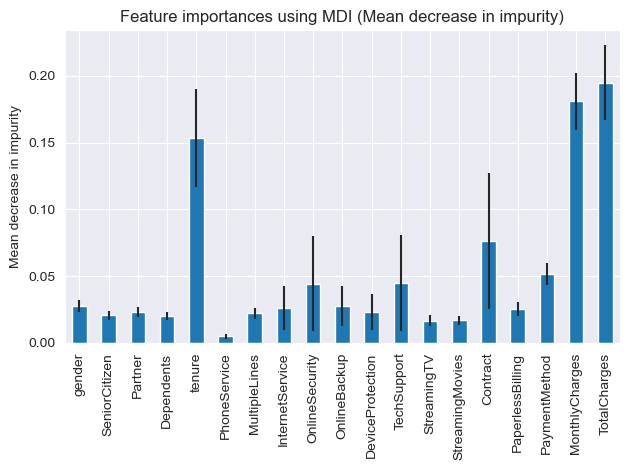

In [4]:
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = split(df.drop("Churn", axis=1),  df["Churn"], test_size=0.1)

forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)
feature_names = X.columns.values.tolist()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances_mdi = pd.Series(importances, index=feature_names)
# print(forest_importances_mdi.sort_values(ascending=False))

# Plot feature importance
fig, ax = plt.subplots()
forest_importances_mdi.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI (Mean decrease in impurity)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Feature ranking method 2 - Permutation Importance

Using a different metric we arrive to the same conclusion about the top features that are most important for this model. These features effect the model accuracy the most.

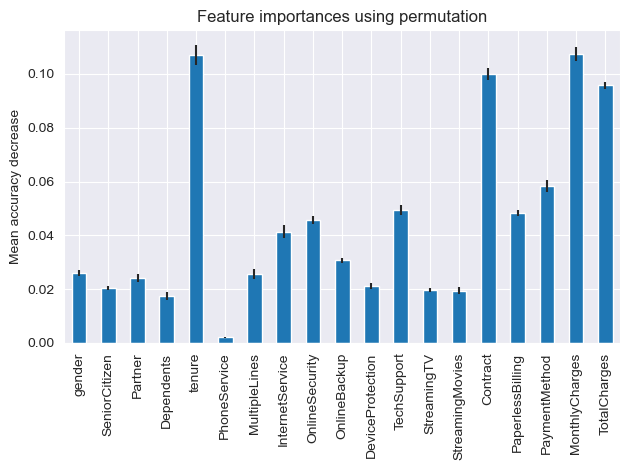

In [5]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X, y, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances_pi = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances_pi.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# print(forest_importances_pi.sort_values(ascending=False))

### Feature-Selection by variance thresholds

Using variance thresholds to select the features we see similar accuracy based on the different thresholds from 80% to 99% but noticeably the features used in the model range from 2 to all features. The middle ground would be using 4 or 5 features as they have very similar performances to using all the features.

In [6]:
# Calculate feature selection table
# We want to remove all features that are either one or zero (on or off) in more than n percent of the samples
threshold_percentiles = [0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
thresholds = [round((probability * (1 - probability)), 3) for probability in threshold_percentiles]
threshold_dict = {
    f'{threshold_percentiles[i]}': forest_importances_mdi[forest_importances_mdi > thresholds[i]].index.tolist()
    for i in range(len(thresholds))
}

threshold_results = { key:[columns] for key, columns in threshold_dict.items()}

for key, columns in threshold_dict.items():
    # fit & train an RF classifier with certain columns that passed threshold
    clf_i = RandomForestClassifier(random_state=0)
    X_train_i = X_train[columns]
    X_test_i = X_test[columns]
    y_pred_i = clf_i.fit(X_train_i, y_train).predict(X_test_i)

    threshold_results[key] = [skm.accuracy_score(y_test, y_pred_i), thresholds[threshold_percentiles.index(float(key))], len(columns), columns]

feature_selection_results = pd.DataFrame.from_dict(threshold_results, orient='index', columns=['Accuracy', 'Threshold',  'K-features', 'Columns'])
feature_selection_results = feature_selection_results.style.set_caption("Accuracy of a RF Classifier using columns within variance threshold")

# Show feature selection vs accuracy results table
display(HTML(feature_selection_results.to_html()))

,Accuracy,Threshold,K-features,Columns
0.8,0.764539,0.160000,2,"['MonthlyCharges', 'TotalCharges']"
0.9,0.746099,0.090000,3,"['tenure', 'MonthlyCharges', 'TotalCharges']"
0.91,0.746099,0.082000,3,"['tenure', 'MonthlyCharges', 'TotalCharges']"
0.92,0.753191,0.074000,4,"['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']"
0.93,0.753191,0.065000,4,"['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']"
0.94,0.753191,0.056000,4,"['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']"
0.95,0.765957,0.048000,5,"['tenure', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"
0.96,0.773050,0.038000,7,"['tenure', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"
0.97,0.773050,0.029000,7,"['tenure', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"
0.98,0.781560,0.020000,16,"['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"


<h1 style='color:orange'>Random Forest Algorithm</h1>

In [7]:
class RFC:
    '''
    Purpose:
        This class performs the same function as sklearn's GridSearchCV, except it saves all the classifiers it trains
        instead of just the "best" one as determined by some scoring function.  In this way, we can compare the effect of
        different hyper parameter combinations on the performance of the forest.
        
        We measure performance with ROC AUC, which was proposed by Probst et. al. (2018) to be a better than the usual
        accuracy measurement.

    Initializing Parameters:
      * hyperParameters = A dict whose keys correspond to the parameters of RandomForestClassifer and whose values are lists
        of arguments for those parameters
      * verbose = Whether to print the parameters used to train each forest
      
    Other notes:
      * Research paper references throughout this Class are done in this manner:
         - Breiman (2001) = B
         - Probst  (2018) = P
        Section and subsection numbers will be added after these aliases like
        B2.1 to show that a comment refers to Breiman (2001) Section 2 Subsection 1
    '''
    def __init__(self, hyperParameters={}, verbose=True):
        hyperParams = \
            self.__getDefaultParams__() if len(hyperParameters) == 0 else self.__validateParams__(hyperParameters)
        self.params = self.__getParamCombos__(hyperParams)
        self.verbose = verbose
        self.classifiers = []
    
    def __getDefaultParams__(self):
        # Supplies default parameters to test based on what our source papers suggest are generally good.
        out = {}
        
        ''' B4
            Suggests selecting more than 1 features to split a node with doesn't perform any better than selecting 1 so long
            as we have a high number of trees.
            
            sklearn sets its default 'max_features'='sqrt', so this is added as one of our defaults to investigate why.  Did
            they find that 'sqrt' performs better than Breiman's suggested 1?
        '''
        out['max_features'] = [1, 'sqrt']
        
        ''' P5.3
            Suggests that the biggest performance gain is experienced by the first 100 trees; however, lower 'max_samples'
            values, lower 'max_depth' values, and higher 'max_features' values reduce inter-tree correlation and therefore
            increase the number of trees needed to reach convergence.
        '''
        out['max_depth'] = [None, 3]
        out['n_estimators'] = [100, 200]
        
        # B3
        # Suggests each bootstrap sample should ideally have 2/3s as many instances as the input.
        out['max_samples'] = [float(2/3)]
        
        # These settings just make sklearn's RFC train faster or be more informative
        out['oob_score'] = [True]
        out['n_jobs'] = [-1]
        return out

    def __validateParams__(self, params):
        ''' Removes any misspelled or non-existent-in-RandomForestClassifier parameter name keys from the dict passed in by
            the caller.
        '''
        VALID = ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf',
                 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'boostrap',
                 'oob_score','n_jobs', 'random_state', 'verbose', 'warm_start', 'class_weight', 'ccp_alpha', 'max_samples']
        invalidKeys = []
        validatedParams = deepcopy(params)
        for key in params:
            if key not in VALID:
                validatedParams.pop(key)
                invalidKeys += [key]
        if len(invalidKeys) > 0:
            print("These are not valid RandomForestClassifier parameter names:\n{}\n".format(invalidKeys) + \
                  "They will not be tested\n")
        return validatedParams if len(validatedParams) > 0 else self.__getDefaultParams__()
    
    def __getParamCombos__(self, dictParams):
        ''' Assemble a dict for each unique combination of hyper parameters.  These dicts can be passed into a function to
            supply keyword arguments
        '''
        combinations = []
        for param, valList in dictParams.items():
            if len(combinations) > 0:
                for i in range(len(combinations)):
                    base = combinations.pop(0)
                    for val in valList:
                        newCombo = deepcopy(base)
                        newCombo[param] = val
                        combinations.append(newCombo)
            else:
                for val in valList:
                    combinations.append({param: val})
        return combinations
    
    def train(self, trainX, trainY):
        '''
        Purpose:
            Train an RFC for each unique combination of hyperparameters
        Code references:
          * Passing named arguments to a function with a dict of names,vals
            https://stackoverflow.com/questions/334655/passing-a-dictionary-to-a-function-as-keyword-parameters
        '''
        if self.verbose:
            print("Training {} classifiers...".format(len(self.params)))
        for dictParams in self.params:
            if self.verbose:
                print("\t{}".format(dictParams))
            newRfc = RandomForestClassifier(**dictParams)
            newRfc.fit(trainX, trainY)
            self.classifiers.append(newRfc)        
            
    def showRocAuc(self, testX, testY):
        # Plots the ROC curve for each classifier this class trained for visual comparison
        if len(self.classifiers) == 0:
            raise AttributeError("No classifiers have been trained yet.  You must call .train() to create " + \
                                 "some classifiers to display.")
        
        fig = plt.figure(dpi=300)
        axes = plt.gca()
        for i in range(len(self.classifiers)):
            skm.RocCurveDisplay.from_estimator(
                self.classifiers[i],
                testX,
                testY,
                pos_label=0,
                name="RFC #{}".format(i+1),
                ax=axes)
            
    def computeRocAuc(self, testX, testY):
        # Returns the AUC scores for each classifier this class has trained
        if len(self.classifiers) == 0:
            raise AttributeError("No classifiers have been trained yet.  You must call .train() to create " + \
                                 "some classifiers to display.")
        
        scores = []
        for clf in self.classifiers:
            scores.append(skm.roc_auc_score(testY, clf.predict_proba(testX)[:, 1]))
        return np.array(scores)

<h1 style='color:orange'>Hyperparameter Performance Comparisons</h1>

## Random Search, Top Results
We searched with RandomSearch with N = 1000 iterations and found the following results below.

The top performing hyperparameters based on this table were

```{'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.6666666666666666, 'max_features': 'auto', 'max_depth': 230}```

![Random Search Output](hyperparameter_search_results.png)


In [32]:
# Optimal Hyper-parameter Search using RandomSearch
parameters = {
    'n_estimators':[int(x) for x in np.linspace(start = 5, stop = 20, num = 16)],
    'max_depth': [int(x) for x in np.linspace(10, 1000, 10)],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_split': [2, 5, 8, 11, 14],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_samples': [float(2/3), 0.5, None],
}

# Classifier
rf_clf = RandomForestClassifier(oob_score=True, n_jobs=-1)

# N-iterations
n_iterations = 1000
# n_iterations = 10 # set to 10 for development

# 10-fold cross validation
k_fold = 10

# Columns to display
df_display_columns = ['rank_test_score', 'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_fit_time']

# Randomized Search
clf_rs = RandomizedSearchCV(estimator=rf_clf, param_distributions=parameters, cv=k_fold, return_train_score=True, scoring='accuracy', n_iter=n_iterations)
start = time.time()
search = clf_rs.fit(X_train, y_train)
stop = time.time()
df_rs = pd.DataFrame(clf_rs.cv_results_)

print('Best Parameters', search.best_params_, '\n')
print('RandomSearch Results, Ranked by Accuracy')
print(f'Total Fit Time: {round(stop - start, 2)}s')
print(f'N-Iterations: {n_iterations}')
display(HTML(df_rs[df_display_columns].sort_values('rank_test_score').to_html()))

Best Parameters {'n_estimators': 16, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 670} 

RandomSearch Results, Ranked by Accuracy
Total Fit Time: 681.0s
N-Iterations: 1000


,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_fit_time
444,1,0.805615,0.837716,16,log2,670,11,6,0.059631
819,2,0.805300,0.849882,18,log2,670,14,2,0.067293
309,3,0.805300,0.858105,17,sqrt,560,11,6,0.064781
693,4,0.804987,0.836051,11,sqrt,230,8,8,0.047623
703,5,0.804828,0.846166,18,auto,1000,2,8,0.068072
255,6,0.804826,0.845324,14,log2,340,11,8,0.055829
165,7,0.804668,0.837295,18,sqrt,670,8,8,0.065502
967,8,0.804512,0.836016,19,log2,230,11,8,0.066736
845,8,0.804512,0.831072,15,auto,340,14,8,0.056134
786,10,0.804356,0.846201,19,auto,890,2,6,0.068909


In [9]:
def testNaPreprocessing(itersPerDataset):
    ''' Tests the effects of how we choose to treat missing values in the dataset.  It averages the ROC AUC scores each
        dataset was able to achieve with a constant set of RFC hyperparameters but without a constant random seed.  
    '''
    dfs = (df_0, df_d, df_m)
    names = (
        'Replaced w/ 0\'s\t',
        'Removed instances',
        'Replaced w/ mean'
    )
    avgAuc = []
    for df in dfs:
        summ = np.zeros(1)
        for j in range(itersPerDataset):
            rfc = RFC(
                {
                    'max_features': [1],
                    'max_depth': [None],
                    'n_estimators': [100],
                    'max_samples': [float(2/3)],
                    'oob_score': [True],
                    'n_jobs': [-1]
                },
                verbose = False
            )
            xTr, xTe, yTr, yTe = split(
                df[['tenure', 'Contract','PaymentMethod',  'MonthlyCharges', 'TotalCharges']],
                df["Churn"],
                test_size=0.1)
            rfc.train(xTr, yTr)
            summ += rfc.computeRocAuc(xTe, yTe)
        avgAuc += [summ / itersPerDataset]
    for i in range(len(dfs)):
        print('{}\t{}'.format(names[i], avgAuc[i]))

testNaPreprocessing(100)

Replaced w/ 0's		[0.81060371]
Removed instances	[0.80897789]
Replaced w/ mean	[0.81196947]


After training 100 forests with each preprocessed dataset, no statistically significant difference was found.  This suggests that, for this churn dataset, it doesn't matter what we do with our missing values.

This is likely because the number of instances with missing values is a very small fraction of the total number of instances in the dataset.  What we do with this small fraction barely affects the dataset overall.

The slight differences in scores exhibited above can be attributed to random luck.  There is an aspect of randomness in what instances end up in the training sample during the train_test_split and in how each Random Forest Classifier is trained.

In [10]:
def testMaxDepth(iters, maxDepth=[1,2,None], valueNames=['1:\t','2:\t','Unlimited:']):
    ''' This function tests the effects of maximum depth for each tree in a forest by averaging the scores of _iters_
        forests trained with each max_depth setting
    '''
    xTr, xTe, yTr, yTe = split(
        df_m[['tenure', 'Contract','PaymentMethod',  'MonthlyCharges', 'TotalCharges']],
        df_m["Churn"],
        test_size=0.1)
    avgAuc = np.zeros(len(maxDepth))
    for i in range(iters):
        rfc = RFC(
            {
                'max_features': [1],
                'max_depth': maxDepth,
                'n_estimators': [100],
                'max_samples': [float(2/3)],
                'oob_score': [True],
                'n_jobs': [-1]
            },
            verbose = False
        )
        rfc.train(xTr, yTr)
        avgAuc += rfc.computeRocAuc(xTe, yTe)
    avgAuc = avgAuc / iters
    for i in range(len(maxDepth)):
        print('{}\t{:.0%}'.format(valueNames[i], avgAuc[i]))
        
testMaxDepth(100)

1:		81%
2:		83%
Unlimited:	81%


From the average results of 100 iterations, we can see examples of underfitting, overfitting, and fitting well enough.

When trees are limited to only 1 level, it predictably leads to lower scores due to underfitting the training data.  Whether an individual tree predicts correctly is very much left up to chance, depending on whether the algorithm happens to select the most informative feature for the instances bagged for that tree or not.

When the trees are not limited at all, we see that the algorithm is free to overfit the training data.  Allowing further node splitting until all leaves are pure leads to lower scores on average, as seen by "Unlimited:..." above.

From prior testing not shown, we have observed that any small values between the two extremes above tends to perform better on average.  Higher values achieve roughly similar scores, and even higher values trend towards overfitting.  As such, we conclude that this churn dataset only needs a maximum depth of 2 to achieve optimum performance.  This is because we are able to train our forests faster with this smaller max depth and still achieve relatively high scores.

In [11]:
def testMaxFeatures(iters, maxFeatures=[1, 3, None], valueNames=['1:', '3:', 'M:']):
    ''' Tests the effects of max features for each tree in a forest by averaging the scores of _iters_ forests trained with
        each max_features setting
    '''
    xTr, xTe, yTr, yTe = split(
        df_m[['tenure', 'Contract','PaymentMethod',  'MonthlyCharges', 'TotalCharges']],
        df_m["Churn"],
        test_size=0.1)
    avgAuc = np.zeros(len(maxFeatures))
    for i in range(iters):
        rfc = RFC(
            {
                'max_features': maxFeatures,
                'max_depth': [2],
                'n_estimators': [100],
                'max_samples': [float(2/3)],
                'oob_score': [True],
                'n_jobs': [-1]
            },
            verbose = False
        )
        rfc.train(xTr, yTr)
        avgAuc += rfc.computeRocAuc(xTe, yTe)
    avgAuc = avgAuc / iters
    for i in range(len(maxFeatures)):
        print('{}\t{:.1%}'.format(valueNames[i], avgAuc[i]))
        
testMaxFeatures(100, [1,2,3,4,5], ['1:','2:','3:','4:','5:'])

1:	82.9%
2:	83.4%
3:	83.6%
4:	83.1%
5:	82.7%


max_features controls how many features are chosen at random to decide each node split on.  Higher values of this parameter will result in less inter-tree correlation, meaning each tree's path to a classification will be less likely to use the same feature selections as another tree in the forest.

After testing for all possible values of this hyper parameter for our post-feature selection dataset, it appears that max_features=2 performs better on average but not by a significantly large margin, so the differences between different values for this hyper parameter are not significant.

In [12]:
def testMaxSamples(iters, maxSamples=[0.5,float(2/3),None], valueNames=['0.50:\t','0.66:\t','Len(X):\t']):
    ''' Tests the effects of max sample size for each tree in a forest by averaging the scores of _iters_ forests trained
        with each max_samples setting
    '''
    xTr, xTe, yTr, yTe = split(
        df_m[['tenure', 'Contract','PaymentMethod',  'MonthlyCharges', 'TotalCharges']],
        df_m["Churn"],
        test_size=0.1)
    avgAuc = np.zeros(len(maxSamples))
    for i in range(iters):
        rfc = RFC(
            {
                'max_features': [2],
                'max_depth': [2],
                'n_estimators': [100],
                'max_samples': maxSamples,
                'oob_score': [True],
                'n_jobs': [-1]
            },
            verbose = False
        )
        rfc.train(xTr, yTr)
        avgAuc += rfc.computeRocAuc(xTe, yTe)
    avgAuc = avgAuc / iters
    for i in range(len(maxSamples)):
        print('{}\t{:.1%}'.format(valueNames[i], avgAuc[i]))
        
testMaxSamples(100, [0.1, 0.2, 0.3, 0.4, 0.5], ['0.1:','0.2:','0.3:','0.4:','0.5:'])

0.1:	81.7%
0.2:	81.6%
0.3:	81.6%
0.4:	81.5%
0.5:	81.5%


max_samples controls how many instances are added to a bootstrap sample to train a tree on in the forest.  In Breiman's paper, he suggested that 2/3s the length of the input dataset tends to perform the best; however, interestingly, our initial tests showed no significant difference in performance between this size, 1/2 the length of the input, and the length of the input.  

Seeing this, we tested how low we could take this hyper parameter while still maintaining the same level of average performance.  A smaller sample size would result in quicker training times and would be advantageous.  Notably, even taking max sample size down to just 1/10 the length of the input still resulted in the same performance on average.

<h1 style='color:orange'>Hyperparameter Confusion Matrix and Heatmap</h1>

We found the model to have an accuracy of 79% and a very high precision for class 0, which would be when the customer did not churn. We can see that we don't have the same support for each class, and the class 0 having much more support was correlated with much higher overall scores which is expected.

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       571
           1       0.47      0.66      0.55       134

    accuracy                           0.79       705
   macro avg       0.69      0.74      0.71       705
weighted avg       0.83      0.79      0.81       705



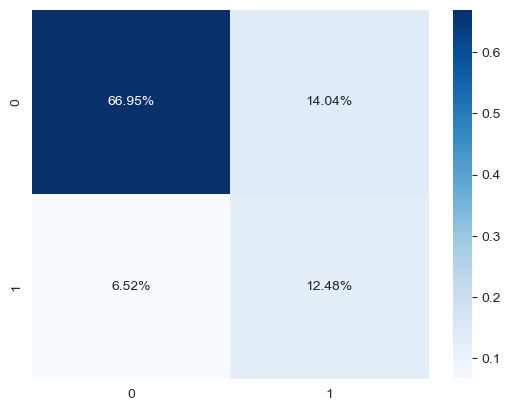

In [39]:
## Metrics

## based on optimal hyper-parameters
best_params = {'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.6666666666666666, 'max_features': 'auto', 'max_depth': 230}
# best_params = {'n_estimators': 16, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 670}
default_params = { 'oob_score': True, 'n_jobs': -1 }
best_params.update(default_params)

rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train,y_train)

# Get predictions
y_pred = rfc.predict(X_test)

# Confusion Matrix
cf = skm.confusion_matrix(y_pred, y_test)
sns.heatmap(cf/np.sum(cf), fmt='.2%', annot=True, cmap='Blues')

# Classification Report
print(skm.classification_report(y_pred, y_test))

<h1 style='color:orange'>Comparision with other ML algorithms</h1>

## Overview

We have selected a black box algorithm provided by a commercial ML/AI package. Salesforce Einstein Discovery is a cloud-based analytics tool that makes it easier for business user to create ML models without writing any code. If we dig a little deeper, the technique used is Generalized Linear Model (GLM). It doesn't specify what specific implemenation but it provides AUC and other metrics to show the performance of the model.  

## Feature Selection

When you create a model, it shows the features selected based on the importance. Similar to Mean decrease in impurity and feature permutation, the cloud platform selects the most important and relevant features automatically. 

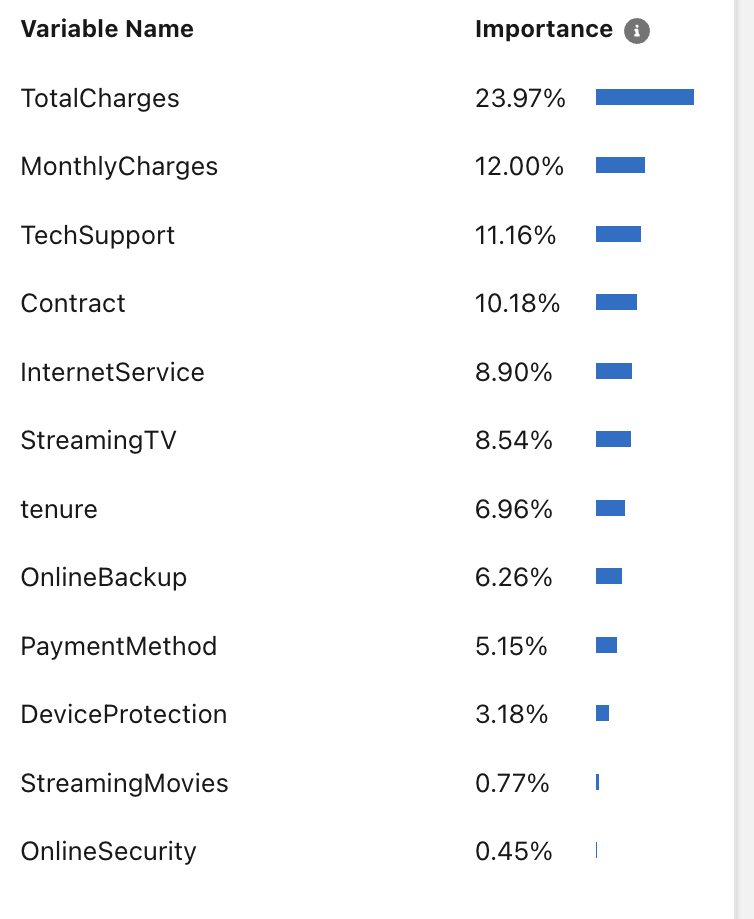

## Model performance

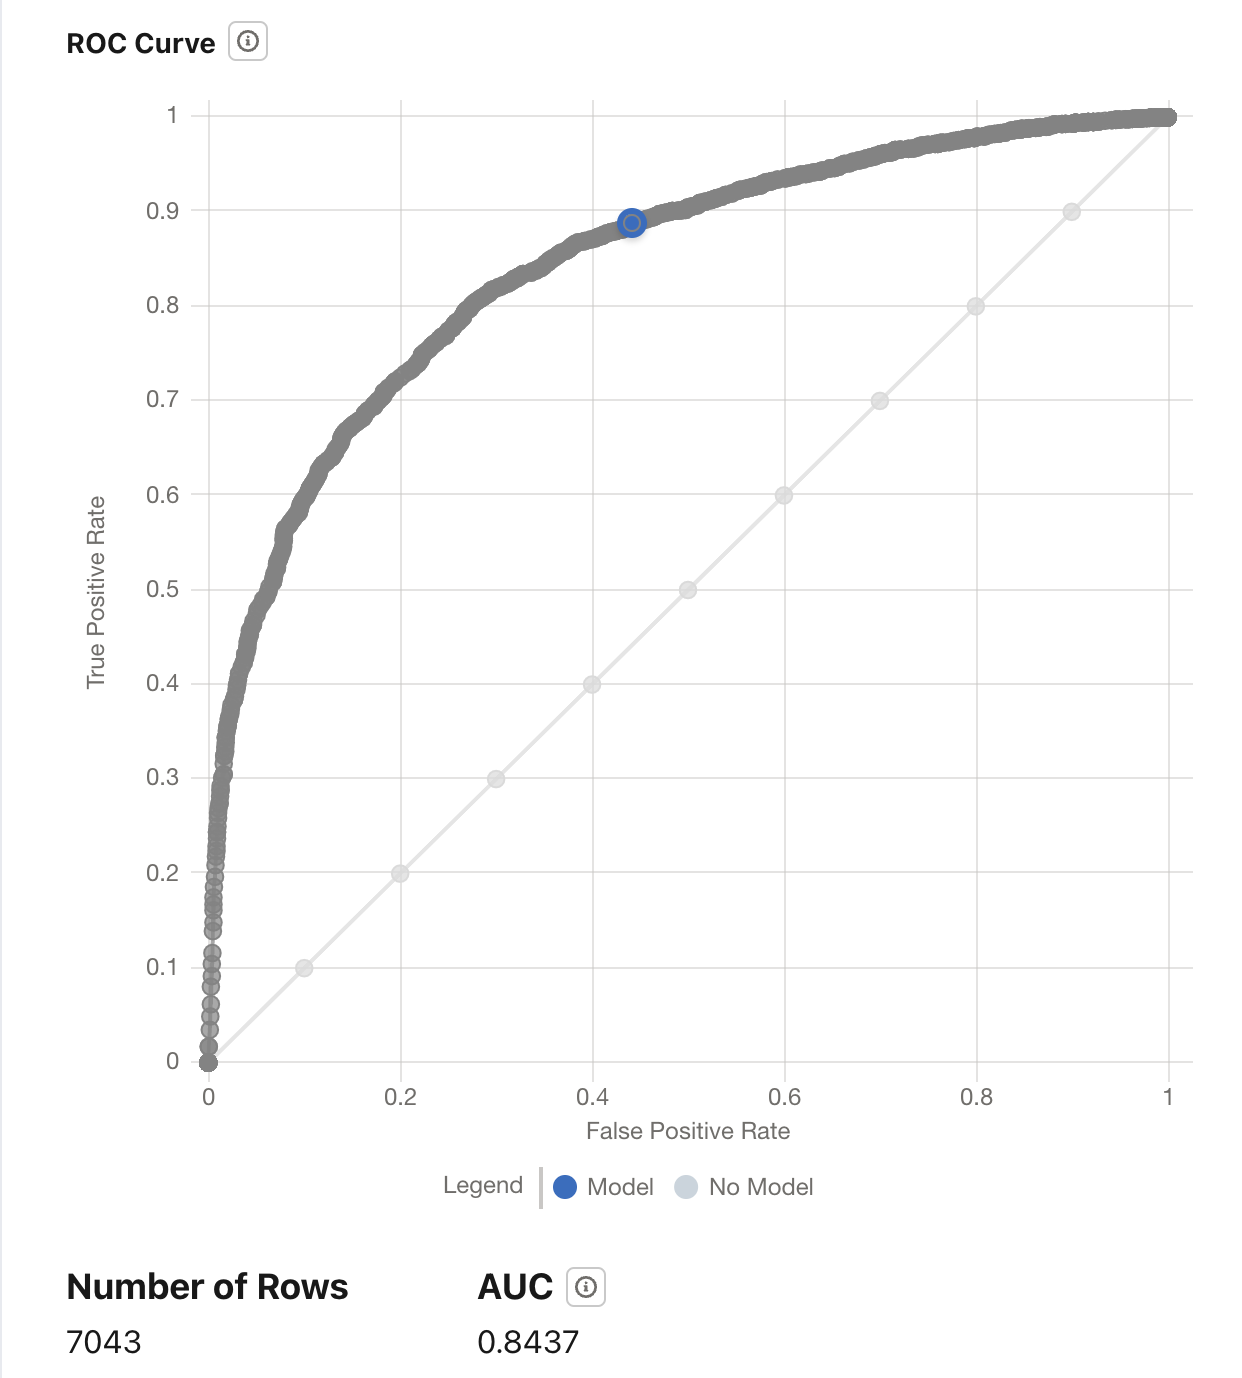

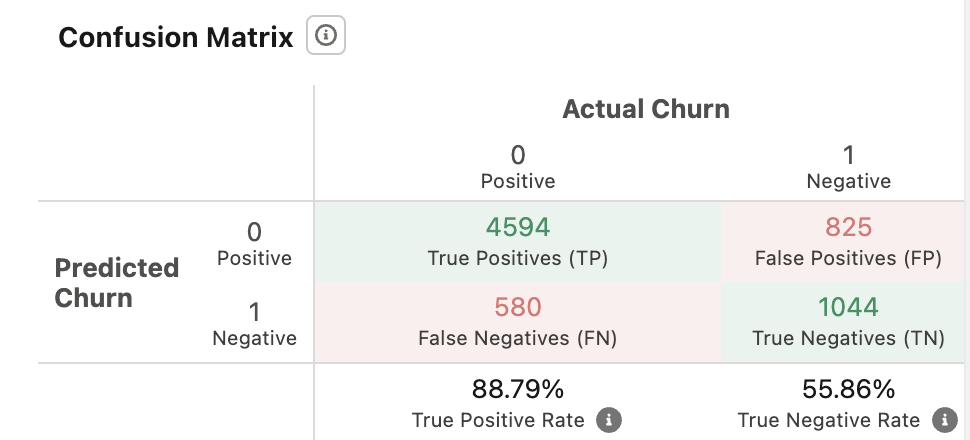